In [1]:
import pandas as pd
from config import weather_key
from config import geo_key
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats 
import linregress
import folium


In [2]:
FY23 = "Resources/FY23.csv"
FY24 = "Resources/FY24.csv"

# Read the CSV files into DataFrames
FY23_df = pd.read_csv(FY23)
FY24_df = pd.read_csv(FY24)

### Create a data frame using both CSV's

In [3]:
FY23 = "Resources/FY23.csv"
FY24 = "Resources/FY24.csv"

# Read the CSV files into DataFrames
FY23_df = pd.read_csv(FY23)
FY24_df = pd.read_csv(FY24)

# Concatenate the DataFrames
combined_df = pd.concat([FY23_df, FY24_df])

# Remove rows with exactly the same values
combined_df = combined_df.drop_duplicates()

# Convert 'appt date' column to datetime format
combined_df['appt date'] = pd.to_datetime(combined_df['appt date'], format='%m/%d/%y')

# Sort the combined DataFrame by the 'appt date' column and reset index
sorted_df = combined_df.sort_values(by='appt date').reset_index(drop=True)

sorted_df


,patient id,check in date,appt date,patient age,patient zip,school code,appt type,act score,school days missed,er visits,hospitalizations
0,13403,6/29/23,2022-07-13,9,60629,NaN,NEW PATIENT 45,15.0,0.0,0.0,0.0
1,17896,3/22/23,2022-07-13,7,60629,334,NEW PATIENT 45,24.0,0.0,2.0,8.0
2,20749,3/15/23,2022-07-13,5,60629,334,NEW PATIENT 45,99.0,0.0,0.0,0.0
3,20788,3/16/23,2022-07-13,9,60629,334,SKIN TEST 45,17.0,10.0,0.0,0.0
4,11825,6/29/23,2022-07-13,11,60629,334,NEW PATIENT 45,24.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
5482,21723,3/28/24,2024-03-28,13,60632,310.0,Telehealth,NaN,NaN,NaN,NaN
5483,21723,3/28/24,2024-03-28,13,60632,310.0,Telehealth,25.0,0.0,0.0,0.0
5484,21443,3/28/24,2024-03-28,16,60632,310.0,Telehealth,20.0,0.0,0.0,0.0
5485,19705,3/28/24,2024-03-28,14,60632,310.0,Telehealth,24.0,0.0,0.0,0.0


### Find the number of unique patients

In [4]:
#Find the number of unique patients

# Count the number of unique values in the 'column_name' column
unique_values_count = sorted_df['patient id'].nunique()

print("Unique Patient ID's:", unique_values_count)

Unique Patient ID's: 1116


# What are the demographics of the patients?

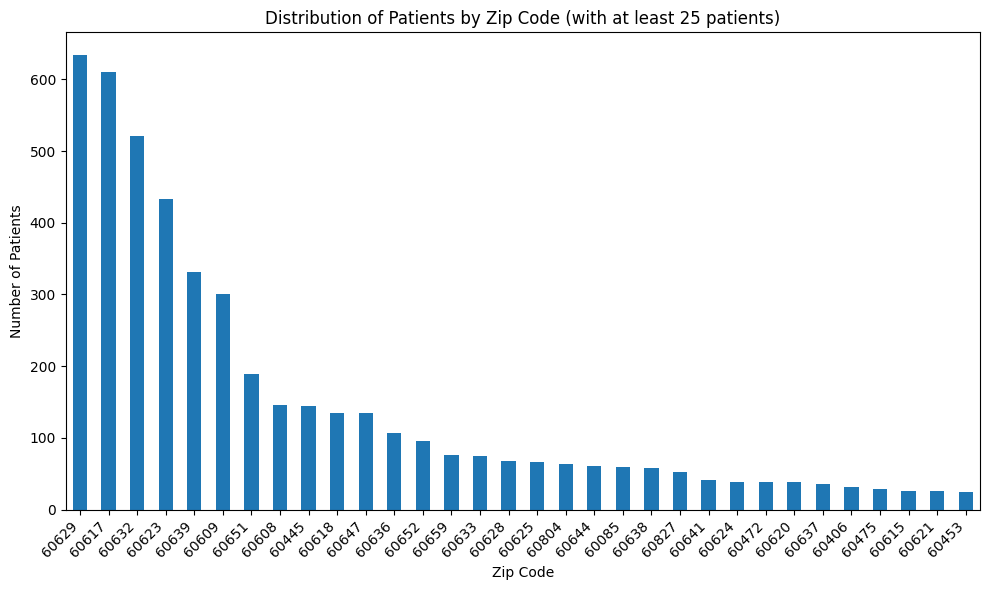

In [13]:
# Calculate the counts of patients for each zip code
zip_counts =sorted_df['patient zip'].value_counts()

# Filter zip codes with fewer than 25 patients
zip_counts_filtered = zip_counts[zip_counts >= 25]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
zip_counts_filtered.plot(kind='bar')
plt.title('Distribution of Patients by Zip Code (with at least 25 patients)')
plt.xlabel('Zip Code')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

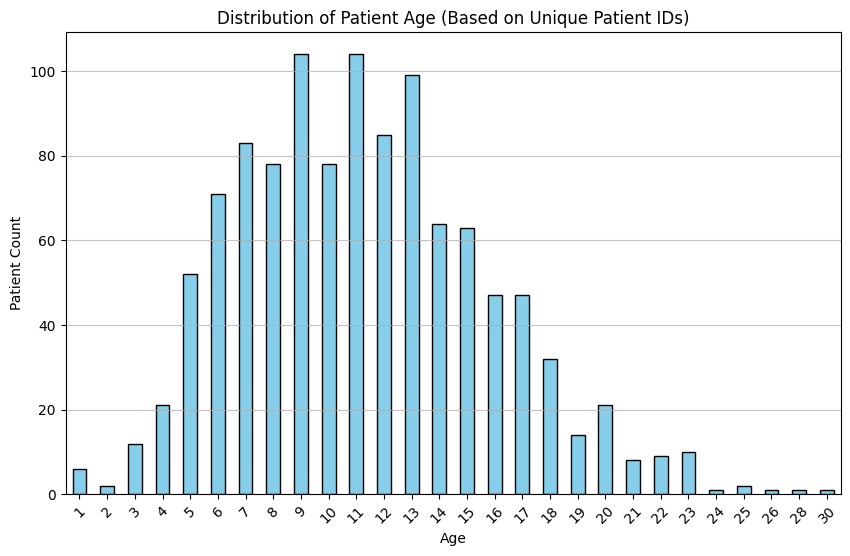

In [6]:
# Group sorted_df by patient ID and count the occurrences of each age
patient_age_counts = sorted_df.groupby('patient id')['patient age'].first().value_counts()

# Sort the patient age counts by age
patient_age_counts_sorted = patient_age_counts.sort_index()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
patient_age_counts_sorted.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Patient Age (Based on Unique Patient IDs)')
plt.xlabel('Age')
plt.ylabel('Patient Count')
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=45)
plt.show()



In [7]:
# Aggregate patient data by ZIP code to calculate patient density
patient_density = sorted_df['patient zip'].value_counts().reset_index()
patient_density.columns = ['patient_zip', 'patient_count']

# Load the GeoJSON file containing ZIP code boundaries for Chicagoland
geojson_file = 'https://raw.githubusercontent.com/smartchicago/chicago-atlas/master/db/import/zipcodes.geojson'

# Create a Folium map centered on Chicagoland
chicago_map = folium.Map(location=[41.8781, -87.6298], zoom_start=10)

# Add a choropleth layer to the map to visualize patient density by ZIP code
folium.Choropleth(
    geo_data=geojson_file,
    name='choropleth',
    data=patient_density,
    columns=['patient_zip', 'patient_count'],
    key_on='feature.properties.ZIP',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Patient Density',
    bins=10,  # Use 10 bins
    fill_scale=(1, 1000)  # Set the range of values for the legend key
).add_to(chicago_map)

# Display the map
chicago_map.save('patient_density_map.html')

chicago_map




# ACT Scores

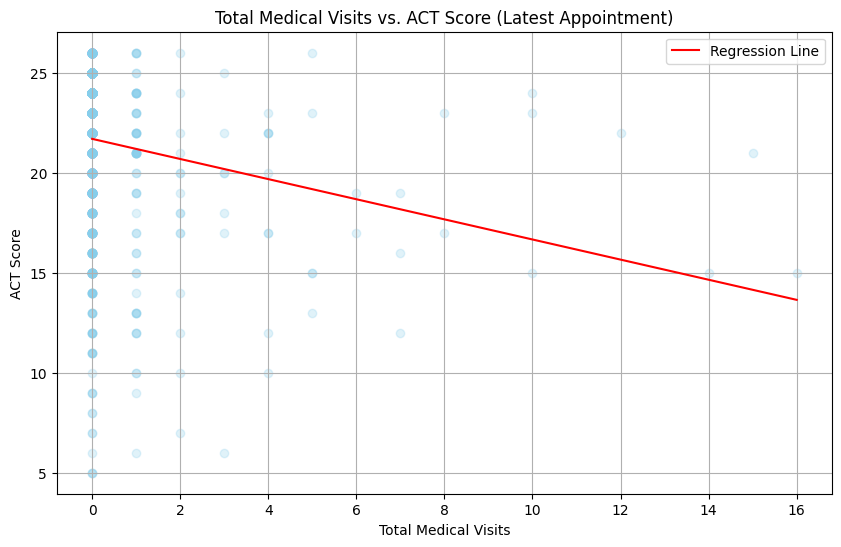

In [9]:
# Filter out rows with NaN or scores over 26, and medical visits over 60
filtered_df = sorted_df.dropna(subset=['act score'])
filtered_df = filtered_df[(filtered_df['act score'] <= 26) & 
                          (filtered_df['hospitalizations'] + filtered_df['er visits'] <= 80)]

# Group by 'patient id' and select the last instance of each patient ID
latest_appt_df = filtered_df.groupby('patient id').last()

# Calculate the total number of medical visits for each patient ID from the same appointment date
latest_appt_df['total_medical_visits'] = latest_appt_df['hospitalizations'] + latest_appt_df['er visits']

# Plot the ACT score against the total number of medical visits with flipped axes
plt.figure(figsize=(10, 6))
plt.scatter(latest_appt_df['total_medical_visits'], latest_appt_df['act score'], color='skyblue', alpha=0.25)

# Perform linear regression with flipped axes
slope, intercept, r_value, p_value, std_err = linregress(latest_appt_df['total_medical_visits'], latest_appt_df['act score'])

# Plot the regression line
x_values = np.linspace(latest_appt_df['total_medical_visits'].min(), latest_appt_df['total_medical_visits'].max(), 100)
plt.plot(x_values, slope * x_values + intercept, color='red', label='Regression Line')

# Add labels and title with flipped axes
plt.title('Total Medical Visits vs. ACT Score (Latest Appointment)')
plt.xlabel('Total Medical Visits')
plt.ylabel('ACT Score')

# Show plot
plt.grid(True)
plt.legend()
plt.show()



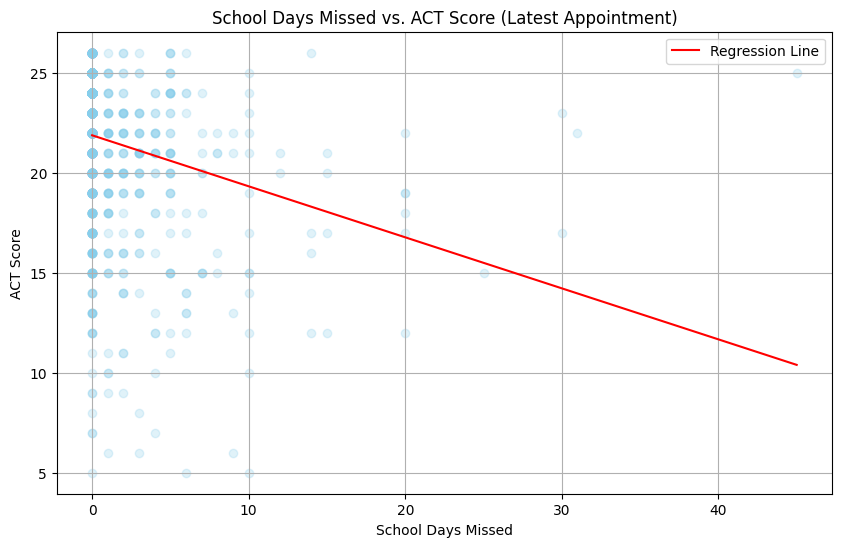

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Filter out rows with NaN or scores over 26, and school days missed over 50
filtered_df2 = sorted_df.dropna(subset=['act score'])
filtered_df2 = filtered_df2[(filtered_df2['act score'] <= 26) & 
                          (filtered_df2['school days missed'] <= 98)]

# Group by 'patient id' and select the last instance of each patient ID
latest_appt_df = filtered_df2.groupby('patient id').last()

# Plot the ACT score against the total number of medical visits with flipped axes
plt.figure(figsize=(10, 6))
plt.scatter(latest_appt_df['school days missed'], latest_appt_df['act score'], color='skyblue', alpha=0.25)

# Perform linear regression with flipped axes
slope, intercept, r_value, p_value, std_err = linregress(latest_appt_df['school days missed'], latest_appt_df['act score'])

# Plot the regression line
x_values = np.linspace(latest_appt_df['school days missed'].min(), latest_appt_df['school days missed'].max(), 100)
plt.plot(x_values, slope * x_values + intercept, color='red', label='Regression Line')

# Add labels and title with flipped axes
plt.title('School Days Missed vs. ACT Score (Latest Appointment)')
plt.xlabel('School Days Missed')
plt.ylabel('ACT Score')

# Show plot
plt.grid(True)
plt.legend()
plt.show()


In [11]:
# Filter out rows with invalid ACT scores
valid_scores_df = sorted_df[(sorted_df['act score'] <= 26) & 
                            (sorted_df['act score'].notna())]

# Group by patient ID and count the number of unique appointment dates
patient_appointment_counts = valid_scores_df.groupby('patient id')['appt date'].nunique()

# Filter patient IDs with at least 4 different appointment dates
four_or_more_dates_ids = patient_appointment_counts[patient_appointment_counts >= 4].index

# Filter the DataFrame based on the selected patient IDs
four_or_more_dates_df = valid_scores_df[valid_scores_df['patient id'].isin(four_or_more_dates_ids)]

# Group by patient ID and select the first and last appointment scores
first_last_scores_df = four_or_more_dates_df.groupby('patient id').agg(first_score=('act score', 'first'),
                                                                      last_score=('act score', 'last'))

# Calculate the difference between first and last appointment scores
first_last_scores_df['score_difference'] = first_last_scores_df['last_score'] - first_last_scores_df['first_score']

# Create a new DataFrame to store the comparison of first and last scores
first_last_comparison_df = pd.DataFrame({
    'patient id': first_last_scores_df.index,
    'first_appt_score': first_last_scores_df['first_score'],
    'last_appt_score': first_last_scores_df['last_score'],
    'score_difference': first_last_scores_df['score_difference']
})

# Display the resulting DataFrame
print(first_last_comparison_df)


            patient id  first_appt_score  last_appt_score  score_difference
patient id                                                                 
11115            11115              25.0             24.0              -1.0
11121            11121              24.0             25.0               1.0
11137            11137              25.0             25.0               0.0
11143            11143              17.0             21.0               4.0
11188            11188              26.0             19.0              -7.0
...                ...               ...              ...               ...
22445            22445              11.0             22.0              11.0
22460            22460              11.0             19.0               8.0
22486            22486              14.0             19.0               5.0
22538            22538              21.0             24.0               3.0
22844            22844              24.0             20.0              -4.0

[282 rows x

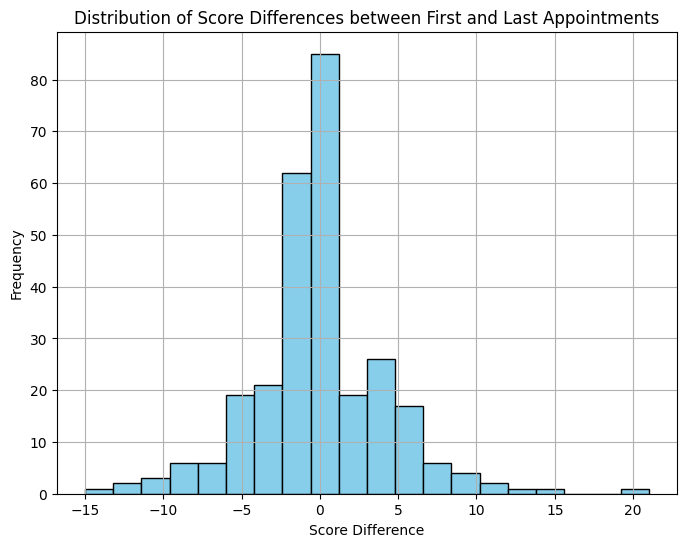

In [12]:
# Plotting histogram of score differences
plt.figure(figsize=(8, 6))
plt.hist(first_last_comparison_df['score_difference'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Score Differences between First and Last Appointments')
plt.xlabel('Score Difference')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
